In [1]:
import os
import torch
import numpy as np
from PIL import Image
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import matplotlib.pyplot as plt

In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='/scratch1/ganesang/nuScenes/mini/', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.857 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [3]:
def rotation_matrix(theta_x, theta_y, theta_z):
    theta_x = (np.pi/180)*theta_x
    theta_y = (np.pi/180)*theta_y
    theta_z = (np.pi/180)*theta_z
    Rx = np.array([[1, 0, 0],
               [0, np.cos(theta_x), -np.sin(theta_x)],
               [0, np.sin(theta_x), np.cos(theta_x)]])
    Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                [0, 1, 0],
                [-np.sin(theta_y), 0, np.cos(theta_y)]])
    Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                [np.sin(theta_z), np.cos(theta_z), 0],
                [0, 0, 1]])
    
    R = Rx@Ry@Rz

    return R

def geometric_transformation(rotation, translation):
    mat = np.eye(4)
    mat[:3, :3] = rotation
    mat[:3, 3] = translation
    return mat

(-0.5, 1599.5, 899.5, -0.5)

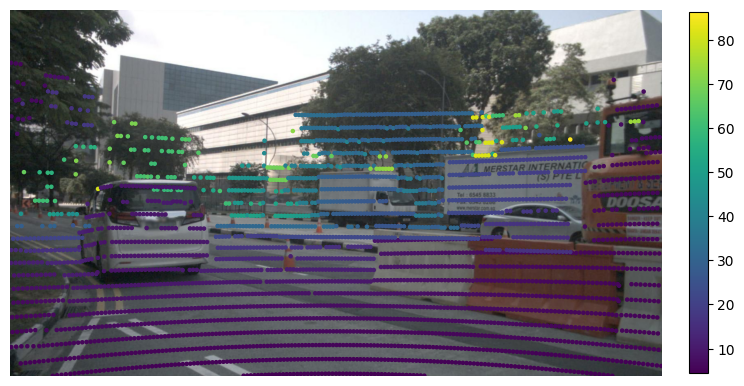

In [40]:
sample = nusc.sample[20]
sample_token = sample['token']
camera_channel = 'CAM_FRONT'
    
sample = nusc.get('sample', sample_token)
lidar_token = sample['data']['LIDAR_TOP']
camera_token = sample['data'][camera_channel]

lidar = nusc.get('sample_data', lidar_token)
cam = nusc.get('sample_data', camera_token)
pcl_path = os.path.join(nusc.dataroot, lidar['filename'])
pc = LidarPointCloud.from_file(pcl_path)
im = Image.open(os.path.join(nusc.dataroot, cam['filename']))

cam_loc_rot_ang = {'CAM_FRONT': 0,
                'CAM_FRONT_RIGHT': -55,
                'CAM_FRONT_LEFT': 55,
                'CAM_BACK': 180,
                'CAM_BACK_RIGHT': -110,
                'CAM_BACK_LEFT': 110}
R_lidar_to_cam = rotation_matrix(90, 0, 0)
R_cam_ang = rotation_matrix(0, cam_loc_rot_ang[camera_channel], 0)
pc.rotate(R_lidar_to_cam)
pc.rotate(R_cam_ang)

cs_record_lidar = nusc.get('calibrated_sensor', lidar['calibrated_sensor_token'])
cs_record_cam = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
poserecord_lidar = nusc.get('ego_pose', lidar['ego_pose_token'])
poserecord_cam = nusc.get('ego_pose', cam['ego_pose_token'])

cam_intrinsic = np.array(cs_record_cam['camera_intrinsic'])

lidar_to_veh_rot = Quaternion(cs_record_lidar['rotation']).rotation_matrix
lidar_to_veh_trans = np.array(cs_record_lidar['translation'])
lidar_to_veh_mat = geometric_transformation(lidar_to_veh_rot, lidar_to_veh_trans)

cam_to_veh_rot = Quaternion(cs_record_cam['rotation']).rotation_matrix
cam_to_veh_trans = np.array(cs_record_cam['translation'])
cam_to_veh_mat = geometric_transformation(cam_to_veh_rot, cam_to_veh_trans)

veh_to_glb_lidar_rot = Quaternion(poserecord_lidar['rotation']).rotation_matrix
veh_to_glb_lidar_trans = np.array(poserecord_lidar['translation'])
veh_to_glb_lidar_mat = geometric_transformation(veh_to_glb_lidar_rot, veh_to_glb_lidar_trans)

veh_to_glb_cam_rot = Quaternion(poserecord_cam['rotation']).rotation_matrix
veh_to_glb_cam_trans = np.array(poserecord_cam['translation'])
veh_to_glb_cam_mat = geometric_transformation(veh_to_glb_cam_rot, veh_to_glb_cam_trans)

#Relative pose from lidar to rgb camera
# relative_pose = lidar_to_veh_mat @ veh_to_glb_lidar_mat @ np.linalg.inv(veh_to_glb_cam_mat) @ np.linalg.inv(cam_to_veh_mat)
relative_pose = np.linalg.inv(cam_to_veh_mat) @ np.linalg.inv(veh_to_glb_cam_mat) @ veh_to_glb_lidar_mat @ lidar_to_veh_mat
#Undo lidar to camera rotation operations
relative_pose = relative_pose @ geometric_transformation(R_lidar_to_cam, 0).T @ geometric_transformation(R_cam_ang, 0).T
pc.transform(relative_pose)
cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
depths = pc.points[2, :]
coloring = depths
points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

min_dist = 1.0
mask = np.ones(depths.shape[0], dtype=bool)
mask = np.logical_and(mask, depths > min_dist)
mask = np.logical_and(mask, points[0, :] > 1)
mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
mask = np.logical_and(mask, points[1, :] > 1)
mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
points = points[:, mask]
coloring = coloring[mask]

dot_size = 5
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(im)
plot = ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
im_ratio = im.size[1]/im.size[0]
fig.colorbar(plot, ax=ax, fraction=0.046*im_ratio, pad=0.04)
ax.axis('off')
# depth = coloring

In [41]:
lidar_file = lidar['filename'].split('/')[-1]
cam_file = cam['filename'].split('/')[-1]
depth_file = os.path.join(os.getcwd(),'nuScenes/filtered_pts',f"{lidar_file}#{cam_file}.pt")

In [42]:
cleaned_depth = torch.load(depth_file)

(-0.5, 1599.5, 899.5, -0.5)

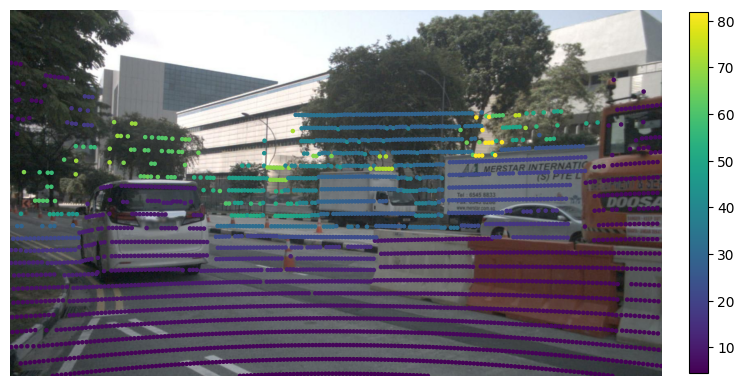

In [43]:
dot_size = 5
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(im)
plot = ax.scatter(cleaned_depth[:, 0], cleaned_depth[:, 1], c=cleaned_depth[:, 2], s=dot_size)
im_ratio = im.size[1]/im.size[0]
fig.colorbar(plot, ax=ax, fraction=0.046*im_ratio, pad=0.04)
ax.axis('off')